The very bottom panel has the equations from temporary polynomial fits. With too high a degree, you can filter out based on relative importance (single zernike coefficients 10x less than no zernikes, double zernikes 100x, etc) and you get things that have at least the right players, and somewhat the same forms modulo the occasional terms oddly out of proportion

In [2]:
%matplotlib inline

In [3]:
# load up relevant packages
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso, LassoLars, Ridge, LinearRegression


# this part taken from https://github.com/mrocklin/multipolyfit/blob/master/multipolyfit/core.py
from numpy import linalg, zeros, ones, hstack, asarray
from itertools import combinations_with_replacement

def basis_vector(n, i):
    """ Return an array like [0, 0, ..., 1, ..., 0, 0]
    >>> from multipolyfit.core import basis_vector
    >>> basis_vector(3, 1)
    array([0, 1, 0])
    >>> basis_vector(5, 4)
    array([0, 0, 0, 0, 1])
    """
    x = zeros(n, dtype=int)
    x[i] = 1
    return x

def as_tall(x):
    """ Turns a row vector into a column vector """
    return x.reshape(x.shape + (1,))

def stack_x(xs, deg):

    num_covariates = xs.shape[1]
    xs = hstack((ones((xs.shape[0], 1), dtype=xs.dtype) , xs))

    generators = [basis_vector(num_covariates+1, i)
                  for i in range(num_covariates+1)]

    # All combinations of degrees
    powers = map(sum, combinations_with_replacement(generators, deg))

    # Raise data to specified degree pattern, stack in order
    A = hstack(asarray([as_tall((xs**p).prod(1)) for p in powers]))

    return A, powers

def power_selector(zi, zj, powers, beta):
    powersum = np.sum(powers[0])
    powers_desired = np.zeros(len(powers[0]), dtype=np.int)
    powers_desired[zi - 3] += 1
    powers_desired[zj - 3] += 1
    powers_desired[0] = powersum - np.sum(powers_desired)
    ith = np.array([np.all(power == powers_desired) for power in powers])
    return beta[ith]

def mk_pretty_function(beta, powers, x_keys=['', 'r0'] + ['z{0}'.format(i) for i in xrange(4, 12)],
                       min_threshold=-20):
    num_covariates = len(powers[0]) - 1
    xs = [''] + x_keys
    terms = []
    keys = []
    for ith in xrange(len(beta)):
        coef = beta[ith]
        # since z is in the range -1 to 1, you can imagine that 
        # each additional zernike requires a compensation in the
        # coefficient by another order of magnitude
        if 'x' in x_keys:
            if_coord = powers[ith][xs.index('x')] * 2
            if_coord += powers[ith][xs.index('y')] * 2
        else:
            if_coord = 0
        if np.abs(coef) < 10 ** (min_threshold - powers[ith][0] + if_coord + np.sum(powers[ith])):
            coef = 0
        power = powers[ith]
        term = '{0:.2e}'.format(coef)
        if term.count('0') == 5:
            continue
        key = ''
        for power_ith in xrange(len(power)):
            term_power = xs[power_ith]
            number_terms = power[power_ith]
            for j in xrange(number_terms):
                key += term_power
        keys.append(key)
        if len(term) > 0:
            terms.append(term)
    # print the terms
    string = ''
    for key, term in zip(keys, terms):
        string += term
        string += ' '
        string += key
        string += ' + '
    return terms, string, keys


In [4]:
# load up the coeffs for lasso and linear
donut_dir = '/Users/cpd/Projects/WavefrontPSF/meshes'

df = pd.read_csv(donut_dir + '/interpolated_zernikes.csv', index_col=0)

x_keys = ['rzero']

for zi in xrange(4, 12):
    zkey = 'z{0}'.format(zi)
    x_keys.append(zkey)

y_keys = ['flux', 'Mx', 'My', 'e0prime', 'e0', 'e1', 'e2',
          'delta1', 'delta2', 'zeta1', 'zeta2']
# fudge
df['e0prime'] = df['e0']
# stack xs
deg = 4  # want 2d polynomial
xs = df[x_keys].values
ys = df[y_keys].values
x_powers, powers = stack_x(xs, deg)


In [5]:
linear = LinearRegression(fit_intercept=False, normalize=False)
linear.coef_ = np.load(donut_dir + '/coeffs_linear.npy')
linear.intercept_ = 0
linear_predict = linear.predict(x_powers)
lasso = Lasso(alpha=1e-3, normalize=False, fit_intercept=False, tol=1e-8)
lasso.fit(x_powers[:10], ys[:10])
lasso.coef_ = np.load(donut_dir + '/coeffs_lasso.npy')
lasso.intercept_ = 0
lasso_predict = lasso.predict(x_powers)


regressor = lasso
predict = lasso_predict

In [6]:
# add these to the df
for y_key_i, y_key in enumerate(y_keys):
    df['linear_{0}'.format(y_key)] = linear_predict[:, y_key_i]
    df['diff_linear_{0}'.format(y_key)] = (linear_predict[:, y_key_i] - df[y_key])
    df['lasso_{0}'.format(y_key)] = lasso_predict[:, y_key_i]
    df['diff_lasso_{0}'.format(y_key)] = (lasso_predict[:, y_key_i] - df[y_key])

In [7]:
from IPython.html.widgets import interact

def func(const_txt='1.', y_key='e0', regression='lasso'):
    if regression == 'lasso':
        regressor = lasso
    elif regression == 'linear':
        regressor = linear
        
    yith = y_keys.index(y_key)

    const = float(const_txt)
    beta = (const * regressor.coef_)[yith]

    terms, string, keys = mk_pretty_function(beta, powers)

    print(y_key + ' = ' + string)
interact(func, y_key=y_keys, regression=['lasso', 'linear'])

e0 = 7.37e-01  + -2.84e+00  + 6.06e-02 r0r0 + 1.31e-02 r0z10 + 3.95e-02 z4z4 + 3.80e-02 z5z5 + 7.61e-02 z6z6 + 7.05e-02 z7z7 + 8.42e-02 z8z8 + 8.39e-02 z9z9 + 1.21e-01 z10z10 + -1.95e-02 z4z6z7z10 + 


<function __main__.func>

<function __main__.func>

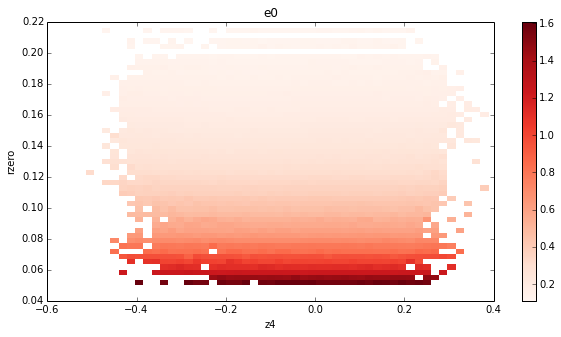

In [8]:
from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(xkey='z4', ykey='rzero', zkey='e0'):
        
    # plot predictions
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey, num_bins=50)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey)
interact(func)

<function __main__.func>

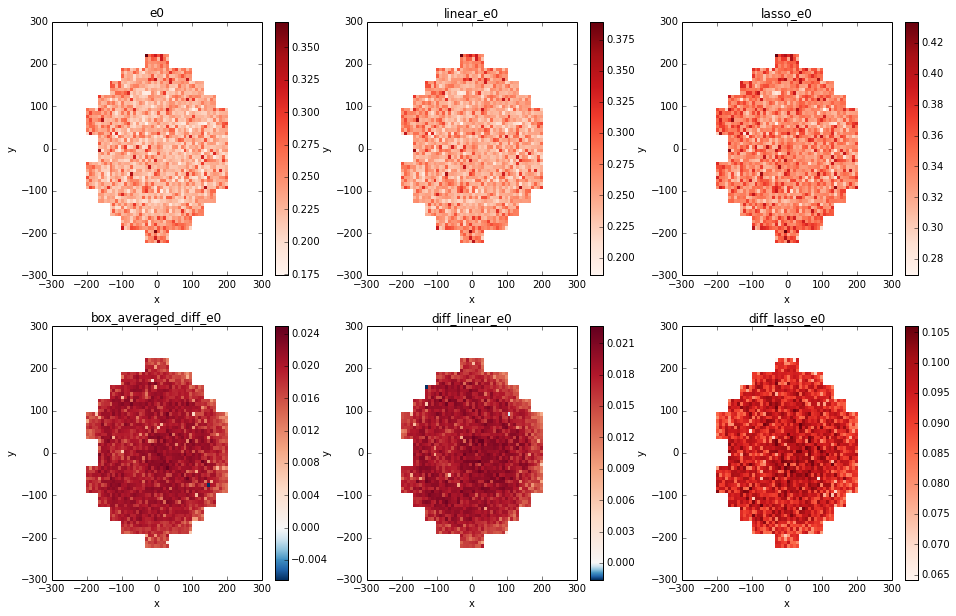

In [9]:
from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(zkey='e0', num_bins=3):
        
    field, bins_x, bins_y = WF.reduce_data_to_field(
                df, xkey='x', ykey='y', num_bins=num_bins)
    xkey = 'x'
    ykey = 'y'
    # plot predictions
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,10))
    ax = axs[0,0]
    fig, ax = WF.plot_field(zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey)

    ax = axs[0,1]
    fig, ax = WF.plot_field('linear_' + zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('linear_' + zkey)
    
    ax = axs[0,2]
    fig, ax = WF.plot_field('lasso_' + zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('lasso_' + zkey)
    
    ax = axs[1,0]
    field['box_averaged_diff'] = field['linear_' + zkey] - field[zkey]
    fig, ax = WF.plot_field('box_averaged_diff', field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('box_averaged_diff_' + zkey)    
    
    ax = axs[1,1]
    fig, ax = WF.plot_field('diff_linear_' + zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('diff_linear_' + zkey)
    
    ax = axs[1,2]
    fig, ax = WF.plot_field('diff_lasso_' + zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('diff_lasso_' + zkey)
interact(func, num_bins=(0,4))

<function __main__.func>

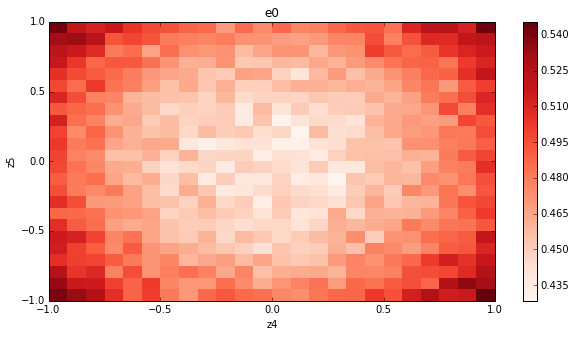

In [10]:
from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(rzero, varcoords=True, num_bins_txt='25', xkey='z4', ykey='z5', zkey='e0'):
    df = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, {True: 'var', False: 'const'}[varcoords]),
                     index_col=0)
    # plot predictions
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey, num_bins=int(num_bins_txt))
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey)
interact(func, rzero=(0,5))

<function __main__.func>

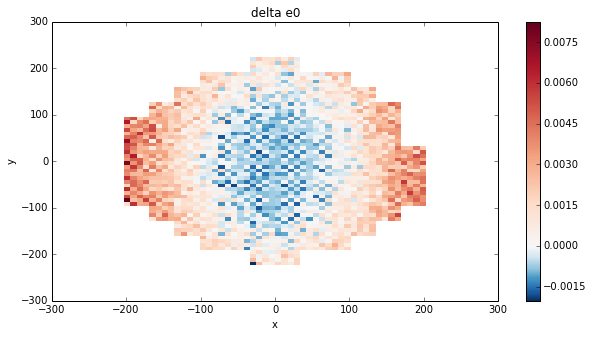

In [11]:
# effects on moments of incorporating focal plane coordinates

from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(rzero, abs=False, num_bins_txt='3', zkey='e0'):
    xkey='x'
    ykey='y'
    df1 = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, 'var'),
                     index_col=0)
    df2 = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, 'const'),
                     index_col=0)
    df1[y_keys] = df1[y_keys] - df2[y_keys]
    if abs:
        for key in y_keys:
            df1[key] = np.abs(df1[key])
    df = df1
    # plot predictions
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey, num_bins=int(num_bins_txt))
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    if abs:
        ax.set_title('abs(delta ' + zkey + ')')
    else:
        ax.set_title('delta ' + zkey)
interact(func, rzero=(0,5))

<function __main__.func>

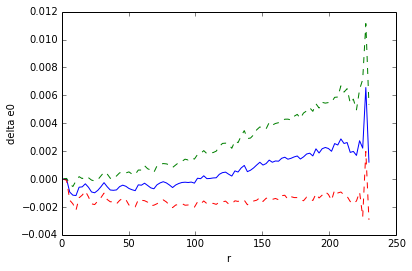

In [12]:
# effects on moments of incorporating focal plane coordinates
def mad(x):
    return np.median(np.abs(x - np.median(x)))
def func(rzero, abs=False, num_bins_txt='100', zkey='e0', xoffset_txt='10'):
    df1 = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, 'var'),
                     index_col=0)
    df2 = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, 'const'),
                     index_col=0)
    xoffset = np.float(xoffset_txt)
    df1[y_keys] = df1[y_keys] - df2[y_keys]
    if abs:
        for key in y_keys:
            df1[key] = np.abs(df1[key])
    df1['r'] = np.sqrt((df1['x'] - xoffset) ** 2 + (df1['y']) ** 2)
    bins_r = np.linspace(df1['r'].min(), df1['r'].max(), int(num_bins_txt))
    groups = df1.groupby(pd.cut(df1['r'], bins_r))
    centers_r = 0.5 * (bins_r[1:] + bins_r[:-1])
    agg = groups.aggregate(np.median)
    agg_mad = groups.aggregate(mad)

    # plot predictions
    fig, ax = plt.subplots()
    ax.set_xlabel('r')

    if abs:
        ax.set_ylabel('abs(delta ' + zkey + ')')
    else:
        ax.set_ylabel('delta ' + zkey)

    ax.plot(centers_r, agg[zkey])
    ax.plot(centers_r, agg[zkey] + agg_mad[zkey], '--')
    ax.plot(centers_r, agg[zkey] - agg_mad[zkey], '--')

interact(func, rzero=(0,5), xoffset_txt=['-10', '0', '10', '-100'])

nan 0.00418058023624 nan
nan 0.00128403634565 nan
nan 0.0197946305561 nan


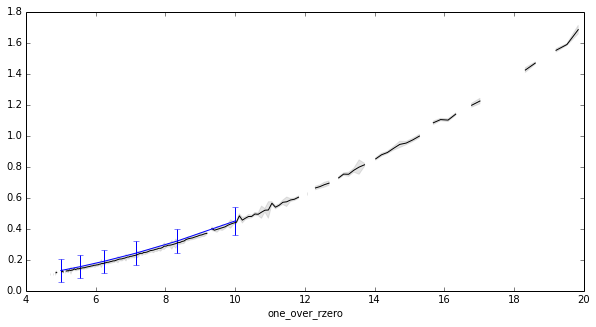

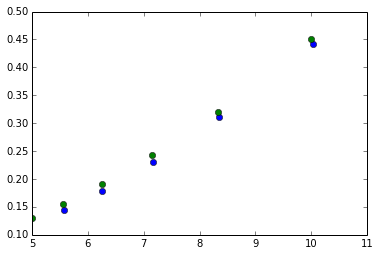

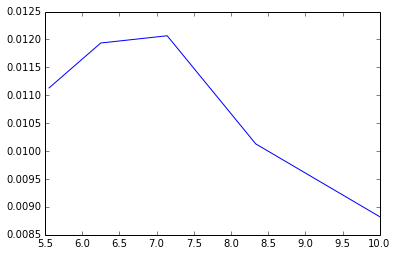

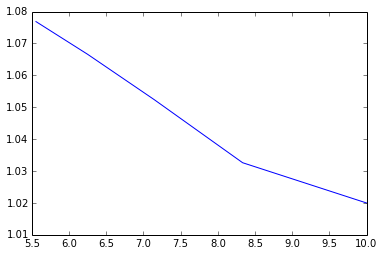

In [25]:
num_bins = 200
df['one_over_rzero'] = 1. / df['rzero']
xkey = 'one_over_rzero'
zkey = 'e0'
bins = np.linspace(np.min(df['rzero']), np.max(df['rzero']), num_bins)
bins = bins[::-1] ** -1
centers = 0.5 * (bins[1:] + bins[:-1])

groups = df.groupby(pd.cut(df[xkey], bins))
agg = groups.aggregate(np.min)
agg2 = groups.aggregate(np.std)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel(xkey)
ax.plot(centers, agg[zkey], 'k-')
ax.fill_between(centers, agg[zkey] - agg2[zkey], agg[zkey] + agg2[zkey], alpha=0.1, color='k')

a, m, b = np.polyfit(centers, agg[zkey], 2)
plt.plot(centers, a * centers ** 2 + centers * m + b, 'k--')

# load up the rzero points to confirm this
for varcoords in [True]:#[True, False]:
    x = []
    y = []
    yerr = []
    for rzero in xrange(6):
        dfi = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
                rzero, {True: 'var', False: 'const'}[varcoords]),
                         index_col=0)
        x.append(np.min(dfi['rzero'].values))
        y.append(np.min(dfi[zkey].values))
        yerr.append(np.std(dfi[zkey].values))
    x = np.array(x)
    x = 1. / x
    a2, m2, b2 = np.polyfit(x, y, 2)
    print(a, a2, a - a2)
    print(m, m2, m - m2)
    print(b, b2, b - b2)
    plt.errorbar(x, y, yerr)
    
    x2 = np.array([centers[np.argmin(np.abs(xi - centers))] for xi in x])
    y2 = np.array([agg[zkey][np.argmin(np.abs(xi - centers))] for xi in x])
    plt.figure()
    plt.plot(x2, y2, 'o')
    plt.plot(x, y, 'o')
    plt.figure()
    plt.plot(x, y - y2)
    plt.figure()
    plt.plot(x, y / y2)

well that's odd: the rzero relationship from one of my files does not match the other. Let's try to get to the bottom of this by creating our own batch of donuts with varying rzeros but fixed everything else.

31, 0.1, -1.02e-01, 2.18e+00, 5.30e+00
100, 1, -7.08e-03, 1.32e-01, 1.54e+01
223, 5, 2.10e-03, -4.86e-02, 1.62e+01
2.25e-03, -4.01e-02, 1.61e+01


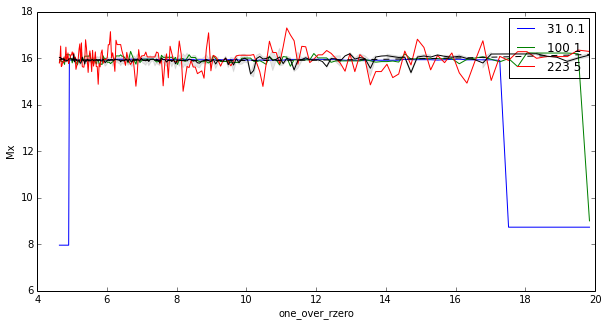

In [14]:
from WavefrontPSF.donutengine import Zernike_to_Pixel_Interpolator
from WavefrontPSF.psf_evaluator import Moment_Evaluator
PSF_Drawer = Zernike_to_Pixel_Interpolator()
PSF_Evaluator = Moment_Evaluator()
def evaluate_psf(data):
    stamps, data = PSF_Drawer(data)
    evaluated_psfs = PSF_Evaluator(stamps)
    # this is sick:
    combined_df = evaluated_psfs.combine_first(data)

    return combined_df

xkey = 'one_over_rzero'
zkey = 'Mx'
bins = np.linspace(np.min(df['rzero']), np.max(df['rzero']), num_bins)
if 'one_over' in xkey:
    bins = bins[::-1] ** -1
centers = 0.5 * (bins[1:] + bins[:-1])
Nsample = 100

fig, ax = plt.subplots(figsize=(10,5))
x = 0
for zsum in [0.1, 1, 5]:
    Nsample = np.int(100 * np.sqrt(zsum))
    data = {'rzero': np.random.random(Nsample) * (np.max(df['rzero']) - np.min(df['rzero'])) + np.min(df['rzero']),
            'x': np.zeros(Nsample) + x,
            'y': np.zeros(Nsample) + x}
    zernikes = np.random.random(size=(8, Nsample)) * 2 - 1
    zernikes = zernikes * zsum / np.abs(zernikes).sum(axis=0)
    for zi, zernike in enumerate(zernikes):
        data['z{0}'.format(zi + 4)] = zernike.flatten()
    data['one_over_rzero'] = 1. / data['rzero']
    df_rzero = evaluate_psf(pd.DataFrame(data))

    groups = df_rzero.groupby(pd.cut(df_rzero[xkey], bins))
    agg = groups.aggregate(np.median)
    ax.set_xlabel(xkey)
    ax.plot(centers, agg[zkey], '-', label='{0} {1}'.format(Nsample, zsum))
    a, m, b = np.polyfit(centers, agg[zkey], 2)
    print('{0}, {1}, {2:.2e}, {3:.2e}, {4:.2e}'.format(Nsample, zsum, a, m, b))


# plot other
groups = df.groupby(pd.cut(df[xkey], bins))
agg = groups.aggregate(np.median)
agg2 = groups.aggregate(np.std)

ax.set_xlabel(xkey)
ax.set_ylabel(zkey)
ax.plot(centers, agg[zkey], 'k-')
ax.fill_between(centers, agg[zkey] - agg2[zkey], agg[zkey] + agg2[zkey], alpha=0.1, color='k')

a, m, b = np.polyfit(centers, agg[zkey], 2)
print('{:.2e}, {:.2e}, {:.2e}'.format(a, m, b))
plt.plot(centers, a * centers ** 2 + centers * m + b, 'k--')
plt.legend()

so my random generation of rzeros matches the interpolated_zernikes.csv ...

what happened with that make_many_donuts?!

In [15]:
x_keys_train = ['x', 'y', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11']

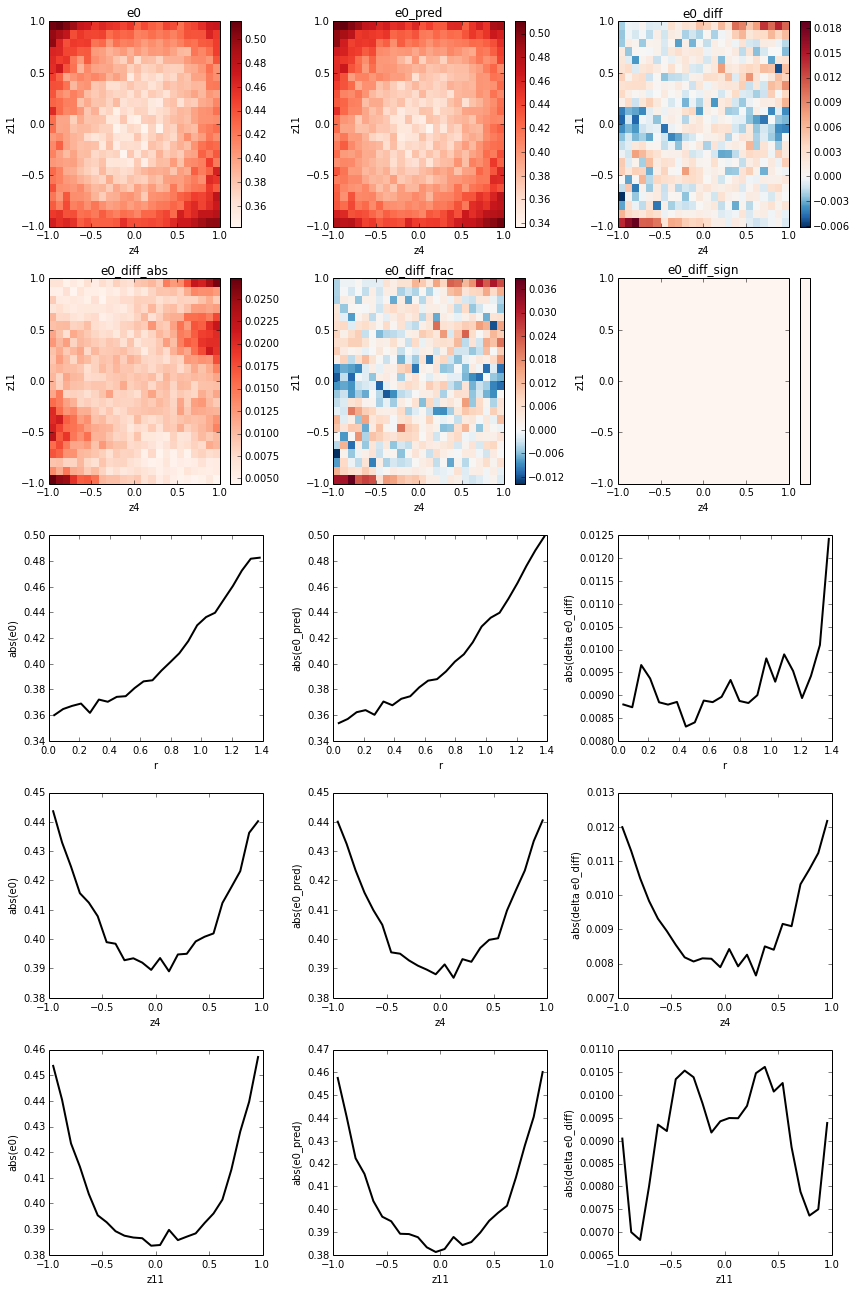

In [29]:
x_keys_train = ['x', 'y', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11']
model = np.load('/Users/cpd/Projects/WavefrontPSF/meshes/Analytic_Coeffs/model.npy').item()

tests = np.load('/Users/cpd/Projects/WavefrontPSF/meshes/Analytic_Coeffs/tests.npy').item()

from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(rzero, varcoords=False, abs=True, num_bins_txt='25', xkey='z4', ykey='z5', zkey='e2'):

    if varcoords:
        x_keys_train_use = x_keys_train
    else:
        x_keys_train_use = x_keys_train[2:]
    rzeros = ['{0:.2f}'.format(0.08 + 0.01 * i) for i in xrange(15)]
    coef, powers, deg, x_keys_train_use, y_keys = model[rzeros[rzero]]
    xs_train, ys_train, xs_test, ys_test, ys_pred = tests[rzeros[rzero]]
#     xs_test, ys_test, ys_pred, coef, powers = model[(varcoords, rzero)]
    if abs:
        ys_test = np.abs(ys_test)
        ys_pred = np.abs(ys_pred)
    df = {xkey: xs_test[:, x_keys_train_use.index(xkey)],
          ykey: xs_test[:, x_keys_train_use.index(ykey)],
          zkey: ys_test[:, y_keys.index(zkey)],
          zkey + '_pred': ys_pred[:, y_keys.index(zkey)],
          zkey + '_diff': -ys_test[:, y_keys.index(zkey)] + ys_pred[:, y_keys.index(zkey)],
          zkey + '_diff_sign': 0.5 * (np.sign(ys_test[:, y_keys.index(zkey)] * ys_pred[:, y_keys.index(zkey)]) + 1),
          zkey + '_diff_abs': np.abs(-ys_test[:, y_keys.index(zkey)] + ys_pred[:, y_keys.index(zkey)]),
          zkey + '_diff_frac': (-ys_test[:, y_keys.index(zkey)] + ys_pred[:, y_keys.index(zkey)]) / ys_test[:, y_keys.index(zkey)]}
    df = pd.DataFrame(df)
    # plot predictions
    fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(12,18))
    ax = axs[0,0]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey, num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey)
    
    # plot predictions
    ax = axs[0,1]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_pred', num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_pred')
    
    # plot difference
    ax = axs[0,2]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_diff', num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_diff')
    
    # plot fractional difference
    ax = axs[1,1]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_diff_frac', num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_diff_frac')
    
    # plot difference
    ax = axs[1,0]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_diff_abs', num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_diff_abs')
    
    # plot the sign difference
    # value in pixel = fraction of values whose signs agreed between prediction and truth
    ax = axs[1,2]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_diff_sign', num_bins=int(num_bins_txt), fig=fig, ax=ax,
                               reducer=np.mean)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_diff_sign')
    
    # do as radial function from center of xkey and ykey
    df['r'] = np.sqrt((df[xkey]) ** 2 + (df[ykey]) ** 2)
    bins_r = np.linspace(df['r'].min(), df['r'].max(), int(num_bins_txt))
    groups = df.groupby(pd.cut(df['r'], bins_r))
    centers_r = 0.5 * (bins_r[1:] + bins_r[:-1])
    agg = groups.aggregate(np.median)
    
    ax = axs[2, 0]
    ax.set_xlabel('r')
    if abs:
        ax.set_ylabel('abs(' + zkey + ')')
    else:
        ax.set_ylabel('' + zkey)
    ax.plot(centers_r, agg[zkey], 'k-', linewidth=2)
    ax = axs[2, 1]
    ax.set_xlabel('r')
    if abs:
        ax.set_ylabel('abs(' + zkey  + '_pred'+ ')')
    else:
        ax.set_ylabel('' + zkey + '_pred')
    ax.plot(centers_r, agg[zkey + '_pred'], 'k-', linewidth=2)
    ax = axs[2, 2]
    ax.set_xlabel('r')
    if abs:
        ax.set_ylabel('abs(delta ' + zkey  + '_diff'+ ')')
        ax.plot(centers_r, agg[zkey + '_diff_abs'], 'k-', linewidth=2)
    else:
        ax.set_ylabel('delta ' + zkey + '_diff')
        ax.plot(centers_r, agg[zkey + '_diff'], 'k-', linewidth=2)
    
    # do as function of each individual axis, too
    bins_r = np.linspace(df[xkey].min(), df[xkey].max(), int(num_bins_txt))
    groups = df.groupby(pd.cut(df[xkey], bins_r))
    centers_r = 0.5 * (bins_r[1:] + bins_r[:-1])
    agg = groups.aggregate(np.median)
    
    ax = axs[3,0]
    ax.set_xlabel(xkey)
    if abs:
        ax.set_ylabel('abs(' + zkey + ')')
    else:
        ax.set_ylabel('' + zkey)
    ax.plot(centers_r, agg[zkey], 'k-', linewidth=2)
    
    ax = axs[3,1]
    ax.set_xlabel(xkey)
    if abs:
        ax.set_ylabel('abs(' + zkey + '_pred' + ')')
    else:
        ax.set_ylabel('' + zkey + '_pred')
    ax.plot(centers_r, agg[zkey + '_pred'], 'k-', linewidth=2)
    
    ax = axs[3,2]
    ax.set_xlabel(xkey)
    if abs:
        ax.set_ylabel('abs(delta ' + zkey + '_diff' + ')')
        ax.plot(centers_r, agg[zkey + '_diff_abs'], 'k-', linewidth=2)
    else:
        ax.set_ylabel('delta ' + zkey + '_diff')
        ax.plot(centers_r, agg[zkey + '_diff'], 'k-', linewidth=2)
    
    bins_r = np.linspace(df[ykey].min(), df[ykey].max(), int(num_bins_txt))
    groups = df.groupby(pd.cut(df[ykey], bins_r))
    centers_r = 0.5 * (bins_r[1:] + bins_r[:-1])
    agg = groups.aggregate(np.median)
    
    ax = axs[4,0]
    ax.set_xlabel(ykey)
    if abs:
        ax.set_ylabel('abs(' + zkey + ')')
    else:
        ax.set_ylabel('' + zkey)
    ax.plot(centers_r, agg[zkey], 'k-', linewidth=2)
    
    ax = axs[4,1]
    ax.set_xlabel(ykey)
    if abs:
        ax.set_ylabel('abs(' + zkey + '_pred' + ')')
    else:
        ax.set_ylabel('' + zkey + '_pred')
    ax.plot(centers_r, agg[zkey + '_pred'], 'k-', linewidth=2)

    ax = axs[4,2]
    ax.set_xlabel(ykey)
    if abs:
        ax.set_ylabel('abs(delta ' + zkey + '_diff' + ')')
        ax.plot(centers_r, agg[zkey + '_diff_abs'], 'k-', linewidth=2)
    else:
        ax.set_ylabel('delta ' + zkey + '_diff')
        ax.plot(centers_r, agg[zkey + '_diff'], 'k-', linewidth=2)
    plt.tight_layout()
    
    return df
interact(func, rzero=(0,14), xkey=x_keys_train, ykey=x_keys_train, zkey=y_keys)

In [31]:
# look at effects on coordinates
def func(rzero1, drzero2, y_key='e0', varcoords=False, min_threshold=-4, const_txt='1'):
    
    rzero2 = rzero1 + drzero2


#     if varcoords:
#         x_keys_train_use = x_keys_train
#     else:
#         x_keys_train_use = x_keys_train[2:]
#     _, _, _, coef1, powers = model[(varcoords, rzero1)]
    rzeros = ['{0:.2f}'.format(0.08 + 0.01 * i) for i in xrange(15)]
    coef1, powers, deg, x_keys_train_use, y_keys = model[rzeros[rzero1]]
    
    yith = y_keys.index(y_key)
    if rzero1 == rzero2:
        coef = coef1
    else:
#         _, _, _, coef2, powers = model[(varcoords, rzero2)]
        coef2, powers, deg, x_keys_train_use, y_keys = model[rzeros[rzero2]]
        coef = (coef1 - coef2)
    const = float(const_txt)
    coef = coef * const
    terms, string, keys = mk_pretty_function(coef[yith], powers, x_keys=x_keys_train_use,
                                       min_threshold=min_threshold)
    print('{0} = {1}'.format(y_key, string))
    
interact(func, rzero1=(0,14), drzero2=(-3,3), y_key=y_keys, min_threshold=(-10,4))

e0 = 1.23e-01  + 6.65e-02 z4z4 + 4.63e-02 z5z5 + 4.63e-02 z6z6 + 8.17e-02 z7z7 + 7.35e-02 z8z8 + 8.86e-02 z9z9 + 9.04e-02 z10z10 + 7.94e-02 z11z11 + 


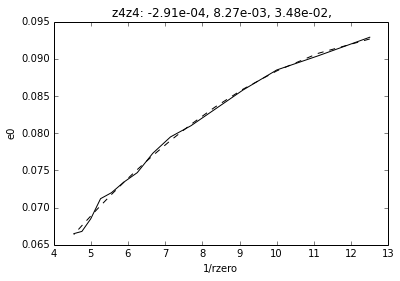

In [34]:
# make plot of rzero scaling
def func(y_key='e0', varcoords=False, flip_rzero=False, rel_1sterm=False, term_keys='', const_txt='1'):
    
    fig, ax = plt.subplots()
    plt.ylabel(y_key)
    terms_keys = term_keys.split(',')

    rzeros = ['{0:.2f}'.format(0.08 + 0.01 * i) for i in xrange(15)]
    
    
    for term_key in terms_keys:
        x_coef = []
        for rzero in xrange(15):
#             if varcoords:
#                 x_keys_train_use = x_keys_train
#             else:
#                 x_keys_train_use = x_keys_train[2:]
#             _, _, _, coef, powers = model[(varcoords, rzero)]
            coef, powers, deg, x_keys_train_use, y_keys = model[rzeros[rzero]]
            yith = y_keys.index(y_key)
            const = float(const_txt)
            coef = coef * const
            terms, string, keys = mk_pretty_function(coef[yith], powers, x_keys=x_keys_train_use)
            ith = keys.index(term_key)

            # technically losing precision here on the terms but that is OK
            x_coef.append(np.float(terms[ith]))

#         rzero = np.array([0.1, 0.12, 0.14, 0.16, 0.18, 0.20])
        rzero = np.array([0.08 + 0.01 * i for i in xrange(15)])
        if flip_rzero:
            rzero = 1. / rzero
            plt.xlabel('1/rzero')
        else:
            plt.xlabel('rzero')
        # do dumb linear fit
        if len(terms_keys) == 1:
            poly = np.polyfit(rzero, x_coef, 2)
            plt.plot(rzero, np.polyval(poly, rzero), 'k--')
            plt.plot(rzero, np.array(x_coef), 'k-')
            title_str = '{0}: '.format(term_key)
            for poly_i in poly:
                title_str += '{0:.2e}, '.format(poly_i)
            plt.title(title_str)
#             plt.title('{2}: {0:.2e}, {1:.2e}'.format(m, b, term_key))
        else:
            X = np.array(x_coef) * 10 ** (-powers[ith][0] + np.sum(powers[ith]))
            if rel_1sterm:
                if term_key == terms_keys[0]:
                    X0 = X
                    m, b = np.polyfit(rzero, X, 1)
                    Xint = b
                else:
                    plt.plot(rzero, (X) / X0, '-',
                             label=term_key + ' x 10^{0}'.format(-powers[ith][0] + np.sum(powers[ith])))
            else:
                plt.plot(rzero, X, '-',
                             label=term_key + ' x 10^{0}'.format(-powers[ith][0] + np.sum(powers[ith])))
    if len(terms_keys) > 1:
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
interact(func, y_key=y_keys)

In [20]:
from WavefrontPSF.wavefront import shift_cmap

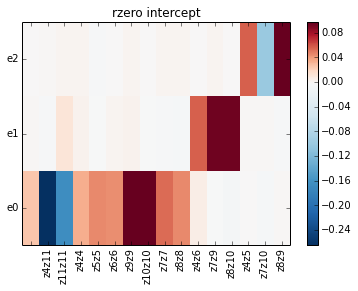

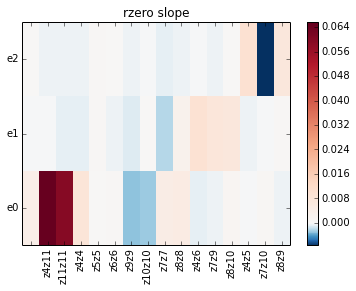

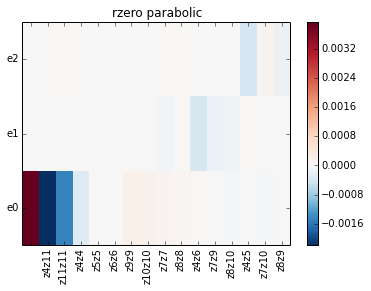

In [36]:
# create matrix of coefficients, see if rzero relationship holds
varcoords = True
flip_rzero = True

a_kij = []
for rzero in xrange(15):
    if varcoords:
        x_keys_train_use = x_keys_train
    else:
        x_keys_train_use = x_keys_train[2:]
        
    rzeros = ['{0:.2f}'.format(0.08 + 0.01 * i) for i in xrange(15)]
    
    
    coef, powers, deg, x_keys_train_use, y_keys = model[rzeros[rzero]]

    # roughly scale coefficients
    powers = np.array(powers)
    #coef = coef * 10 ** (-powers[:, 0][np.newaxis] + np.sum(powers, axis=1))
    a_kij.append(coef)
a_kij = np.array(a_kij)
# rzero = np.array([0.1, 0.12, 0.14, 0.16, 0.18, 0.20])
rzero = np.array([0.08 + 0.01 * i for i in xrange(15)])
if flip_rzero:
    rzero = 1. / rzero
# now optain A_ij, B_ij
A_ij = []
B_ij = []
chi_ij = []
C_ij = []
for i in xrange(a_kij.shape[1]):
    A_ij.append([])
    B_ij.append([])
    C_ij.append([])
    chi_ij.append([])
    for j in xrange(a_kij.shape[2]):
        X = a_kij[:, i, j]

        a, m, b = np.polyfit(rzero, X, 2)
        chi2pdof = np.mean(np.square(a * rzero ** 2 + m * rzero + b - X))
        chi_ij[-1].append(chi2pdof)
        A_ij[-1].append(b)
        B_ij[-1].append(m)
        C_ij[-1].append(a)
A_ij = np.array(A_ij)
B_ij = np.array(B_ij)
C_ij = np.array(C_ij)
chi_ij = np.array(chi_ij)
A_ij_plot = np.sign(A_ij) * np.log10(np.abs(A_ij))
B_ij_plot = np.sign(B_ij) * np.log10(np.abs(B_ij))
chi_ij_plot = np.sign(chi_ij) * np.log10(np.abs(chi_ij))


terms, string, keys = mk_pretty_function(coef[0], powers, x_keys=x_keys_train)
def func(term_keys=',z4z4,z5z5,z6z6,z9z9,z10z10,z7z7,z8z8,z4z6,z7z9,z8z10,z4z5,z7z10,z8z9',
         y_keys_in='e0,e1,e2',shiftcmap=False,abs=False):
#     for yith in xrange(len(y_keys)):
#         for term_key in term_keys.split(','):
#             ith = keys.index(term_key)
#             print('{4} {5}: {0:.2e}, {1:.2e}, {2:.2e}, {3:.2e}'.format(A_ij[yith,ith], B_ij[yith,ith],
#                                                                        B_ij[yith,ith]/A_ij[yith,ith],
#                                                                        chi_ij[yith,ith],
#                                                                        y_keys[yith],
#                                                                        term_key))
    iths = np.array([keys.index(term_key) for term_key in term_keys.split(',')])
    yiths = np.array([y_keys.index(y_key) for y_key in y_keys_in.split(',')])
    
    X = A_ij[np.meshgrid(yiths, iths)].T
    if shiftcmap:
        cmap = shift_cmap(X)
    else:
        cmap = plt.cm.RdBu_r
        if abs:
            cmap = plt.cm.Reds
    if abs:
        X = np.abs(X)
    plt.figure()
    plt.pcolor(X, cmap=cmap)
    plt.xticks(np.arange(len(iths)) + 0.5, term_keys.split(','), rotation='vertical')
    plt.yticks(np.arange(len(yiths)) + 0.5, y_keys_in.split(','))
    plt.colorbar()
    plt.title('rzero intercept')
    
    X = B_ij[np.meshgrid(yiths, iths)].T
    if shiftcmap:
        cmap = shift_cmap(X)
    else:
        cmap = plt.cm.RdBu_r
        if abs:
            cmap = plt.cm.Reds
    if abs:
        X = np.abs(X)
    plt.figure()
    plt.pcolor(X, cmap=cmap)
    plt.xticks(np.arange(len(iths)) + 0.5, term_keys.split(','), rotation='vertical')
    plt.yticks(np.arange(len(yiths)) + 0.5, y_keys_in.split(','))
    plt.colorbar()
    plt.title('rzero slope')
    
    X = C_ij[np.meshgrid(yiths, iths)].T
    if shiftcmap:
        cmap = shift_cmap(X)
    else:
        cmap = plt.cm.RdBu_r
        if abs:
            cmap = plt.cm.Reds
    if abs:
        X = np.abs(X)
    plt.figure()
    plt.pcolor(X, cmap=cmap)
    plt.xticks(np.arange(len(iths)) + 0.5, term_keys.split(','), rotation='vertical')
    plt.yticks(np.arange(len(yiths)) + 0.5, y_keys_in.split(','))
    plt.colorbar()
    plt.title('rzero parabolic')
    
#     X = (B_ij/A_ij)[np.meshgrid(yiths, iths)].T
#     if shiftcmap:
#         cmap = shift_cmap(X)
#     else:
#         cmap = plt.cm.RdBu_r
#         if abs:
#             cmap = plt.cm.Reds
#     if abs:
#         X = np.abs(X)
#     plt.figure()
#     plt.pcolor(X, cmap=cmap)
#     plt.xticks(np.arange(len(iths)) + 0.5, term_keys.split(','), rotation='vertical')
#     plt.yticks(np.arange(len(yiths)) + 0.5, y_keys_in.split(','))
#     plt.colorbar()
#     plt.title('rzero slope / intercept')
    
#     X = chi_ij[np.meshgrid(yiths, iths)].T
#     if shiftcmap:
#         cmap = shift_cmap(X)
#     else:
#         cmap = plt.cm.RdBu_r
#     plt.figure()
#     plt.pcolor(X, cmap=cmap)
#     plt.xticks(np.arange(len(iths)) + 0.5, term_keys.split(','), rotation='vertical')
#     plt.yticks(np.arange(len(yiths)) + 0.5, y_keys_in.split(','))
#     plt.colorbar()
#     plt.title('rzero chi2 per dof')
interact(func)

Look at z2,z3 and Mx relationship

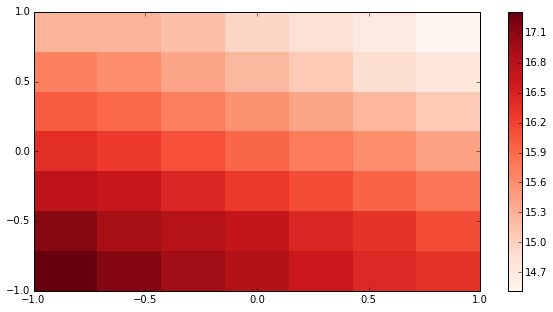

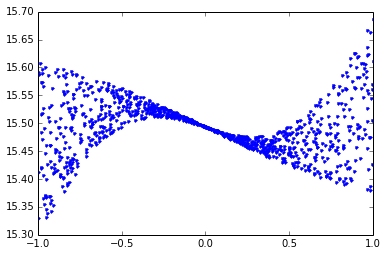

In [23]:
from WavefrontPSF.donutengine import Zernike_to_Pixel_Interpolator
from WavefrontPSF.psf_evaluator import Moment_Evaluator
PSF_Drawer = Zernike_to_Pixel_Interpolator()
PSF_Evaluator = Moment_Evaluator()
def evaluate_psf(data):
    stamps, data = PSF_Drawer(data)
    evaluated_psfs = PSF_Evaluator(stamps)
    # this is sick:
    combined_df = evaluated_psfs.combine_first(data)

    return combined_df

z_trans = np.linspace(-1, 1, 11)
z_tran_deep = []
z_comas = np.linspace(-1, 1, 11)
z_coma_deep = []


z_coma_key = 'z8'
z_tran_key = 'z2'
zkey = 'Mx'



for z_tran in z_trans:
    for z_coma in z_comas:
        z_tran_deep.append(z_tran)
        z_coma_deep.append(z_coma)
Nsample = len(z_tran_deep)
data = {'rzero': np.random.random(Nsample) * (np.max(df['rzero']) - np.min(df['rzero'])) + np.min(df['rzero']),
        'x': np.zeros(Nsample),
        'y': np.zeros(Nsample),
        z_tran_key: z_tran_deep,
        z_coma_key: z_coma_deep}
df_rzero = evaluate_psf(pd.DataFrame(data))

WF.plot_colormap(df_rzero, z_tran_key, z_coma_key, zkey, num_bins=8)

Mfit = LinearRegression(fit_intercept=True, normalize=False)
y = df_rzero[zkey]
X = np.vstack((df_rzero[z_coma_key], df_rzero[z_tran_key])).T
Mfit.fit(X, y)
m_coma, m_tran = Mfit.coef_
b_zkey = Mfit.intercept_

# now test:
Nsample = 1000
z_coma = np.random.random(Nsample) * 2 - 1
z_tran = (15.5 - b_zkey - m_coma * z_coma) / m_tran
data = {'rzero': np.random.random(Nsample) * (np.max(df['rzero']) - np.min(df['rzero'])) + np.min(df['rzero']),
        'x': np.zeros(Nsample),
        'y': np.zeros(Nsample),
        z_tran_key: z_tran,
        z_coma_key: z_coma}
df_rzero = evaluate_psf(pd.DataFrame(data))
plt.figure()
plt.plot(df_rzero[z_coma_key], df_rzero[zkey], '.')

[ -1.65895013e-05  -1.92333003e-05  -5.58257817e-01   1.59375022e+01]
[  1.54345704e-01  -1.32291670e-02  -1.22279075e+00   1.59373467e+01]


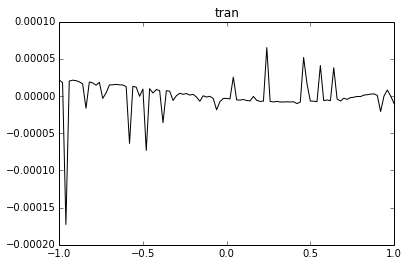

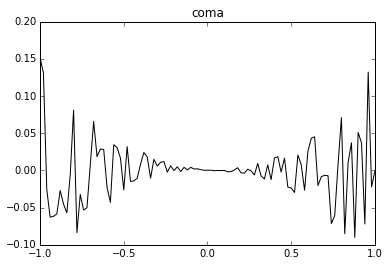

In [24]:
from WavefrontPSF.donutengine import Zernike_to_Pixel_Interpolator
from WavefrontPSF.psf_evaluator import Moment_Evaluator
PSF_Drawer = Zernike_to_Pixel_Interpolator()
PSF_Evaluator = Moment_Evaluator()
def evaluate_psf(data):
    stamps, data = PSF_Drawer(data)
    evaluated_psfs = PSF_Evaluator(stamps)
    # this is sick:
    combined_df = evaluated_psfs.combine_first(data)

    return combined_df

z_tran_deep = np.linspace(-1, 1, 101)
z_coma_deep = np.linspace(-1, 1, 101)

deg = 3
z_coma_key = 'z8'
z_tran_key = 'z2'
zkey = 'Mx'

Nsample = len(z_tran_deep)
data = {'rzero': np.random.random(Nsample) * (np.max(df['rzero']) - np.min(df['rzero'])) + np.min(df['rzero']),
        'x': np.zeros(Nsample),
        'y': np.zeros(Nsample),
        z_tran_key: z_tran_deep}
df_rzero = evaluate_psf(pd.DataFrame(data))

y = df_rzero[zkey]
X = df_rzero[z_tran_key]
arr_tran = np.polyfit(X, y, deg)
plt.figure()
plt.plot(X, y - np.polyval(arr_tran, X), 'k-')
plt.title('tran')
print(arr_tran)

Nsample = len(z_tran_deep)
data = {'rzero': np.random.random(Nsample) * (np.max(df['rzero']) - np.min(df['rzero'])) + np.min(df['rzero']),
        'x': np.zeros(Nsample),
        'y': np.zeros(Nsample),
        z_coma_key: z_coma_deep}
df_rzero = evaluate_psf(pd.DataFrame(data))

y = df_rzero[zkey]
X = df_rzero[z_coma_key]
arr_coma = np.polyfit(X, y, deg)
plt.figure()
plt.plot(X, y - np.polyval(arr_coma, X), 'k-')
plt.title('coma')
print(arr_coma)


